# Linear regression with gradient descent

Gradient descent is omnipresent in the training of neural networks and other machine learning models. Each time you have a model which parameters are updated during the training according to a loss function, you can be almost certain that there is gradient descent under the hood. Here we will see how gradient descent works along a very simple linear regression example.

But before starting, what is a gradient and why descend it?

## Gradient descent, graphically
Imagine you have to approximate a dataset $(X, y)$ where $X$ represents the features of your datapoints and $y$ the target values (to predict) on those datapoints. The goal is to approximate the relationship between $X$ and $y$ by a function $f$ depending on a parameter (weight) $w$, for example $f_p: x \rightarrow w.x$. So you want to find the value of $w$ making $f_w$ the *closest* to $y$. But what does the *closest* means? For this, we use an *error* (also called *cost*) *function* $C$. On a given datapoint $x$, we compute $C(f_w, x, y)$. The higher this value, the worse $f_w$ approximates the data on $x$, so we have to adjust $w$. In machine learning, $f$ would be the model and training the model $f$ means finding the parameter $w$ minimizing $C(f_w, x, y)$ for the datapoints $x$ we have in the training dataset.

So you take a value for $w$, you compute $f_w(x)$, you compare it with the correxponding $y$ from your training dataset. How do you use this information to adjust $w$ in order to reduce this error?
![gradient-descent](img/gradient.png)
Usually the gradient descent is represented visually by small arrows going down the cost function, but this is only part of the story. The *gradient* is in fact the "slope" of the vector orthogonal to the *tangent hyperplane*. Let's first have a short glance at the *tangent hyperplane*. 

**Tangent hyperplane**: *tangent* comes from the Latin and means *touching*. Here the *tangent* is *touching* the cost function at the point corresponding to the current parameter. A *hyperplane* is a plane of dimension $N-1$ in a space of dimension $N$. Here the parameter $p$ is 1-dimensional, so the space is 2-dimensional, it has 2 axis: one for the parameter value, one for the error (cost) value. If $p$ would be 2-dimensional, then the space would be 3-dimensional (2 dimensions for $p$ and 1 for the error), the cost function would be a curved surface in this space, and the *tagent hyperplane* would be a (3-1 = 2)-dimensional plane touching this curve at this point.

The *gradient vector* is the vector generating the line orthogonal to the tangent hyperplane. Then you take the opposite of this vector (hence "descent"), multiply it by the learning rate $lr$. You get the green vector of the schema above. The projection of this vector on the parameter space (here: the x-axis) gives you the new (updated) parameter. Then you repeat this operation several times to go down the cost (error) function, with the goal of reaching a value for $p$ where the cost function is minimal. The parameter is thus updated as follow at each step:
$$ parameter \leftarrow parameter - lr.gradient $$

**Intuition**: Why is this method used, why does it work. Well, imagine $w = (w_1, w_2)$ is 2-dimensional. You test of value of $w$, let say $(3, 2)$ and then see this value is quite wrong. How to adjust it? Increasing $w_1$ and decreasing $w_2$, or this opposite, or increasing both? By how much? You should test then many parameter values around $(3, 2)$ to have an approximative map of the cost function around this point, just to know in what direction to go, then do the same at the new place... it would be extremely computationally intensive, especially if $w$ is like many-millions-dimensional. The gradient is very powerful: for a parameter value, you just have to compute the corresponding  value and gradient of the cost function, and you know where to go.

The thing is, the gradient tells you only the direction, not the distance to go in that direction. If the learning rate is to high, you may go to far in that direction, and possibly completely miss a minimum. Or the learning rate is too small, and you make 10 small steps where one big step would have been enough, thus training your model way too slowly. Finding, optimizing and adapting the learning rate is the topic of ongoing researches for many years, the work done in this area would fill many big books. If you want to go further, [this paper](https://arxiv.org/pdf/1908.06477.pdf) for example benchmarks various learning rate policies that you can research if you're interested.

In the following, we will see how to implement gradient descent and its main variants on a simple example: finding the optimal slope for a 1-dimensional linear regression.

## Example setting
We generate `N=150` points following the distribution $$Y \~ a \times X + \epsilon$$ where $$\epsilon \~ N(0, 10)$$ is a Gaussian white noise, in order to satisfy linear regression conditions. Here $a = 3.2$ is the true value to reach. We will start with $w=10$ and then try to make it reach $3.2$ through gradient descent.

In [9]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [20, 5]

N = 150
a = 3.2
w_start = 10

In [10]:
X = 100 * np.random.random(N)  # `N` random numbers between 0 and 100

# Generate y = a * x + eps where eps is 0-centered Gaussian distributed
Y = np.multiply(X, a)
eps = np.random.normal(scale=10, size=N)
Y = np.add(Y, eps)

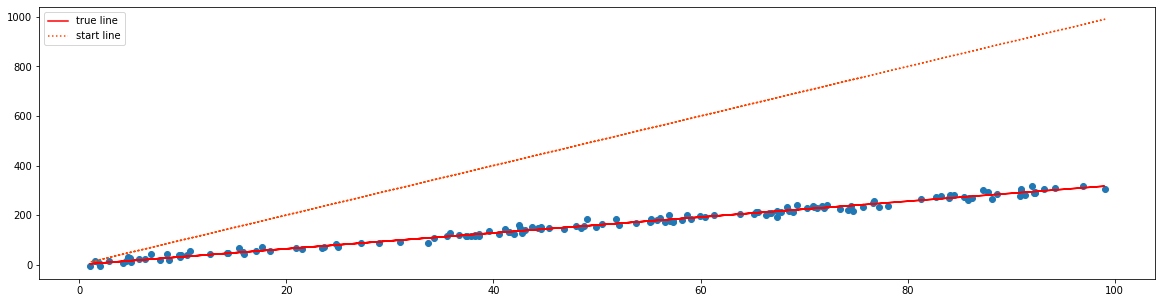

In [11]:
plt.scatter(X, Y)
plt.plot(X, a * X, c='r', label='true line')
plt.plot(X, w_start * X, c='orangered', linestyle='dotted', label='start line')
plt.legend()
plt.show()

*Goal*: make the start line reach the true line through gradient descent.

Following the formalism above:
* $f_w : x \rightarrow w.x$ represented by the dotted line
* $w$: parameter (weight) of the model $f$ representing its slope
* $C : (f_w, x, y) \rightarrow (f_w(x) - y)^2 = (wx - y)^2$ the cost function. It's simply the square of the difference between the value given by the model at $x$ ($wx$) and the true value $y$. Its gradient is given by $\frac{\partial C(f_w, x, y)}{\partial w} = 2x(wx - y)$

## Applying gradient descent


### Stochastic gradient descent
Here we go point by point through the data. At each point, we compute the value given by the current model, the corresponding error, and adjust it by gradient descent. Remember there is another ingredient in the gradient descent, the *learning rate*, determining how far we go in the direction given by the gradient at each step. So we will do this for three difference learning rates: $0.0001$, $0.001$ and $0,01$ and compare the results.

For this, we define a function `gradient_descent_linreg()` iterating through all the points of the `(X, Y)` sample correcting each time `w` according to the loss and learning rate `lr`:

In [12]:
def gradient_descent_linreg(X, Y, lr, w):
    ws, losses = [], []
    for x, y in zip(X, Y):
        loss = (w * x - y) ** 2
        grad = 2 / N * (w * x - y ) * x  # gradient
        w -= lr * grad  # adjust the parameter by gradient descent
        ws.append(w)
        losses.append(loss)
    return {'w': ws, 'loss': losses}

In [13]:
descents = {lr: gradient_descent_linreg(X, Y, lr, w=10) for lr in [.0001, .001, .01]}

In [17]:
def plot_descents_lr(descents, a, batch_size=None):
    cmap = plt.cm.get_cmap('Blues', len(descents) + 1)
    plt.subplot(1, 2, 1)
    for i, (lr, res) in enumerate(descents.items()):
        plt.plot(range(len(res.get('w'))), res.get('w'), c=cmap(i+1), label=f'lr={lr}')
    xmax = max([len(v.get('w')) for v in descents.values()])
    plt.hlines(a, 0, xmax, colors='r', label='True Value')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('w')
    title = 'Estimation of w by Iteration for Various Learning Rates'
    if batch_size:
        title = f'{title}\nBatch Size = {batch_size}'
    plt.title(title)
    
    plt.subplot(1, 2, 2)
    for i, (lr, res) in enumerate(descents.items()):
        plt.plot(range(len(res.get('loss'))), res.get('loss'), c=cmap(i+1), label=f'lr={lr}')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title(title.replace('Estimation', 'Loss'))
    
    plt.show()

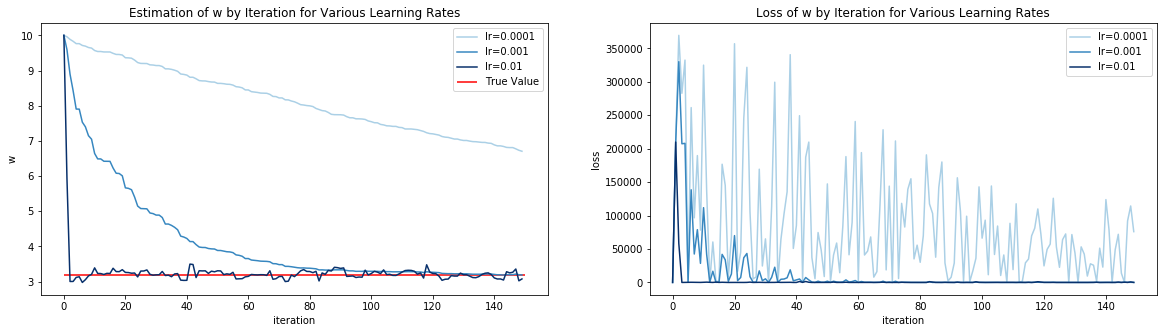

In [18]:
plot_descents_lr(descents, a)

Here we see some interesting things:
* the smallest learning rate $0.0001$ is too small and thus takes too long to make the parameter $w$ reach the true value
* the biggest learning rate $0.01$ brings $w$ very fast to the true value but then oscillates. Being a big step size, it makes $w$ jump too hard and oscillate around the true value
* The intermediate learning rate $0.001$ seems to be a good compromise, taking a bit more time but then stabilizing $w$

### Mini batch
The idea behinf mini-batches is to take a batch of datapoints at each step instead of going point by point, then averaging the error and the gradient obtained for this mini-batch. This has two advantages:
1. You can iterate faster through the data: if the size of the mini-batches is $n$, then you iterate through the training dataset $n$ by $n$ instead of $1$ by $1$
2. The gradient descent is smoother, since the oscillation (loss and gradient value) of the datapoints in the mini-batches are averaged.
On the other hand, taking too big mini-batches would "drown" too much the strongest signals and hinder the gradient descent.
Let's implement it:

In [19]:
def gradient_descent_linreg_batch(X, Y, lr, w, batch_size=5, n_iterations=100):
    ws, losses = [], []
    for _ in range(n_iterations):
        inds = np.random.choice(100, size=batch_size)
        x, y = X[inds], Y[inds]
        loss = np.mean(((w * x) - y) ** 2)
        grad = np.mean(2 / N * (w * x - y ) * x)
        w -= lr * grad
        ws.append(w)
        losses.append(loss)
    return {'w': ws, 'loss': losses}

In [20]:
descents = {lr: gradient_descent_linreg_batch(X, Y, lr, w=10) for lr in [.0001, .001, .01]}

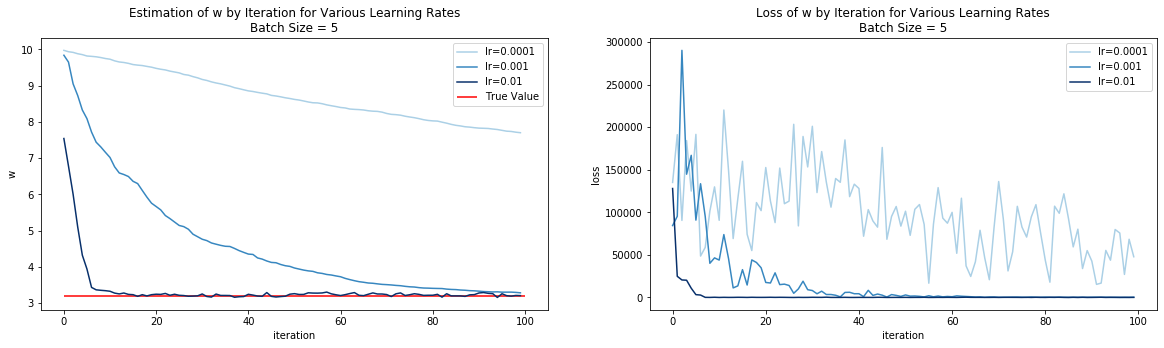

In [21]:
plot_descents_lr(descents, a, batch_size=5)

Here we can see that mini-batching makes the gradient descent slower, but more stable. For example with the highest learning rate $0.01$, the parameter value oscillates less around the true value when it reaches it than previously.

### Momentum
The *momentum* variant of the gradient descent consists in replacing the *gradient* by the *momentum gradient* in the parameter update formula:
$$ w_{t+1} = w_t - lr.m\_gradient_t$$
The *momemtum gradient* $m\_gradient$ is defined iteratively as such:
$$ m\_gradient_t = gradient_t + \alpha. m\_gradient_{t-1} $$
where $\alpha$ is the *momentum coefficient* and  $gradient_t$ is the gradient calculated at the current step from the learning rate and the loss, as we did previously. 

To realize why it's called *momentum*, let's expand this formula:
$$ m\_gradient_t = gradient_t + \alpha. m\_gradient_{t-1} = gradient_t + \alpha. gradient_{t-1} + \alpha^2. m\_gradient_{t-2} = \dots = \sum_{i=0}^n \alpha^i. gradient_{t-i} $$

The term $\sum_{i=0}^n \alpha^i. gradient_{t-i}$ represents the *momentum* of the learning rate trajectory until $t$. The more recent a step, the higher it weights in the momentum. The higher $\alpha$, the higher the previous step will amount in the current *momentum gradient*, hence the higher the momentum.

To illustrate this, let's implement a function taking into account batch size and momentum:

In [22]:
def gradient_descent_linreg_batch_momentum(X, Y, lr, w, batch_size=5, n_iterations=100, alpha=0):
    ws, losses, previous_grad = [], [], 0
    for _ in range(n_iterations):
        inds = np.random.choice(100, size=batch_size)
        x, y = X[inds], Y[inds]
        loss = np.mean(((w * x) - y) ** 2)
        grad = np.mean(2 / N * (w * x - y ) * x)+ alpha * previous_grad
        w -= lr * grad
        ws.append(w)
        losses.append(loss)
        previous_grad = grad
    return {'w': ws, 'loss': losses}

Now we take the second example of before with `lr=0.001` and `batch_size=5` and add to it it different values for the *momentum coefficient* $\alpha$:

In [23]:
descents = {alpha_: gradient_descent_linreg_batch_momentum(X, Y, lr=0.0001, w=10,
                                                           alpha=alpha_) for alpha_ in [.0001, .001, .01]}

In [24]:
def plot_descents_momentum(descents, a, lr, batch_size=None):
    cmap = plt.cm.get_cmap('Blues', len(descents) + 1)
    plt.subplot(1, 2, 1)
    for i, (alpha, res) in enumerate(descents.items()):
        plt.plot(range(len(res.get('w'))), res.get('w'), c=cmap(i+1), label=f'alpha={alpha}')
    xmax = max([len(v.get('w')) for v in descents.values()])
    plt.hlines(a, 0, xmax, colors='r', label='True Value')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('w')
    title = f'Estimation of w by Iteration for Various Momentums\nlearning rate={lr}'
    if batch_size:
        title = f'{title}, batch size = {batch_size}'
    plt.title(title)
    
    plt.subplot(1, 2, 2)
    for i, (alpha, res) in enumerate(descents.items()):
        plt.plot(range(len(res.get('loss'))), res.get('loss'), c=cmap(i+1), label=f'alpha={alpha}')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('w')
    plt.title(title.replace('Estimation', 'Loss'))
    
    plt.show()

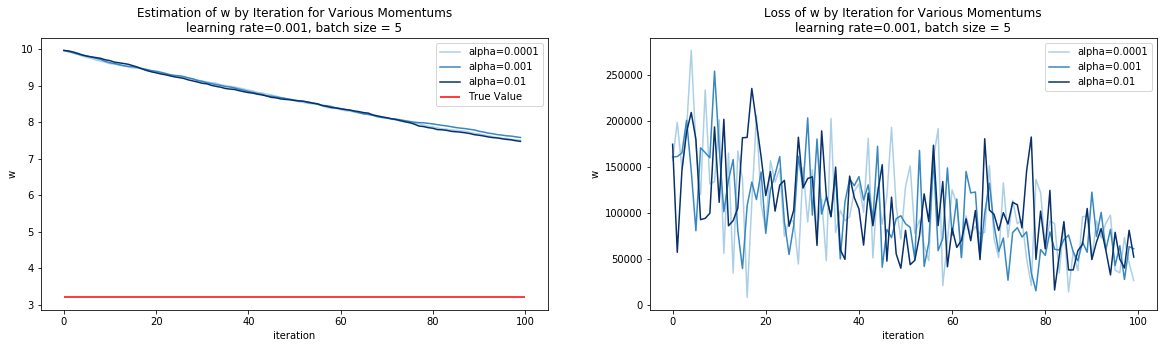

In [25]:
plot_descents_momentum(descents, a, lr=0.001, batch_size=5)

A higher momentum has a further regularization effect on the loss during the training. On the right plot you can see for example that the loss at the beginning doesnt peak as high at the beginning with a higher momentum coefficient $\alpha$. he influence on the convergence speed is however quite modest, as you can see on the left. Why is a smoothy loss relevant? Because as the loss conditions (together with the learning rate) the amplitude of the correction in the model, a too strong loss due to irregularity can make your model miss the convergence to a local optimum, especially in highly dimensional parameter spaces. Still, the effect of the momentum is not as strong as for the learning rate. It's for a reason that [Bengio](https://en.wikipedia.org/wiki/Yoshua_Bengio) considered in his [recommandations](https://arxiv.org/abs/1206.5533) that the learning rate is the most important hyperparameter in a neural network.

There are variants of this *momentum* approach such as [RMSProp](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a) (used for example by [Google Deepmind](https://deepmind.com/)) where the momemtum is increased in the direction where the slope is the strongest, so that the parameter focuses on the direction improving it most without moving around it.

## Conclusion
Gradient descend is an ubiquitous technique in machine learning, especially in deep learning. It's often very helpful to keep in mind what happenns behind the scene when gradient descent is used to train a model. It helps to evaluate what happens and ponder the different options to better train the model.

This article aims to give a first approach to this technique on a simple example. When training model with high dimensional parameters, other phenomens related to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) can occur that we barely touched here. Bear also in mind that in a complex model, there can be many locals minima. Considering how to adjust the gradient descent in order to be able to leave "bad" minima (too shallow/narrow) is also important in this case.

When training a neural network, the piece in charge of managing the gradient descent is called the *optimizer*. There are for example different kind of [optimizers in Keras](https://keras.io/api/optimizers/) and other machine learning frameworks, you can also define your own. We hope this article can help you visualizing and understanding what they do.

In general, implementing a method on a simple toy example (as we did here with the 1-dimensional linear regression) really helps grasping the main ideas behind it.